In [88]:
import scipy.constants
from scipy.constants import physical_constants
import numpy as np
import seaborn as sb
from numpy import exp, sqrt, sin
from math import factorial
import itertools
import matplotlib.pyplot as plt

In [2]:
import importlib
import sys, os
from pathlib import Path
sys.path.append('../tools/')
import IonChainTools as ict
import MSFidelityEstimation as msfe
importlib.reload(msfe)
from MSFidelityEstimation import *

# QSCOUT Params

We pick parameters to match the specifications in the literature.

In [3]:
# Ytterbium171
M=171*physical_constants['atomic mass constant'][0]

# Laser wavelength
# carrier_wavelen = # 355*1e-9 # 355nm, from "frequency robust ..." paper
# carrier_wavenum = 2*π/carrier_wavelen # Laser wavenumber (k)
# carrier_freq = scipy.constants.c*carrier_wavenum
qbit_splitting = 2*π*12.643*1e6 # qubit splitting, from "Engineering The ..." paper
raman_wavelen = 355*1e-9 # 355nm, from "frequency robust ..." paper
raman_freq = 2*π*scipy.constants.c/raman_wavelen
kvec = qbit_splitting/scipy.constants.c*np.sqrt(2)

# Rabi rate
Ωpeak = 2*π*190*1e3 # 190MHz, quoted in "Frequency-robust MS ..." paper

In [4]:
# Trap specifications
# Axial COM of 0.52MHz and highest radial mode of 2.296MHz are quoted in 
# "Frequency-robust Mølmer-Sørensen gates via balanced contributions of multiple motional modes"
νz = 2*π*0.52*1e6 # 0.52MHz, not used here since we adjust νz to fix ion spacing
νr = 2*π*2.296*1e6 # 2.296MHz

In [5]:
# Optical Crosstalk, from "ENGINEERING THE QUANTUM SCIENTIFIC COMPUTING OPEN USER TESTBED"
# These values are scaled such that Ω=1 for the target ion
neighΩ = 0.0236 # Rabi frequency on neighbor of target ion
nneighΩ = 0.006 # Rabi frequency on next neighbor of target ion

In [6]:
# Blue and Red beam phases
# Below should implement X gate
ϕB = π/2
ϕR = π/2

# Rabi Crosstalk Measurement

Population increase due to crosstalk on neighbor and next-neighbor

In [7]:
def rabi(Ω,t):
    return np.sin(Ω*t/2)**2

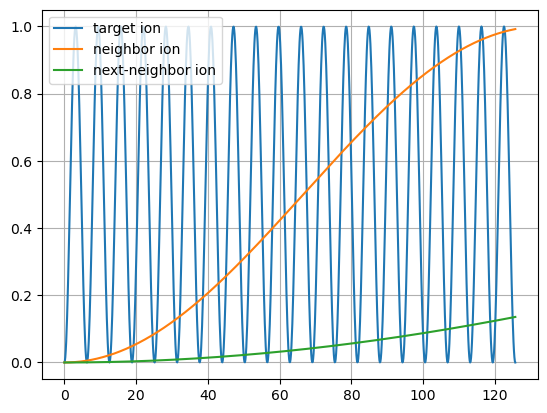

In [8]:
fig,ax = plt.subplots(1,1)

ts = np.linspace(0,20*2*pi,1000)

ax.plot(ts,rabi(1,ts),label = 'target ion')
ax.plot(ts,rabi(neighΩ,ts),label = 'neighbor ion')
ax.plot(ts,rabi(nneighΩ,ts),label = 'next-neighbor ion')

ax.legend(loc='upper left')
ax.grid(True)
plt.show()

# MS Optical Crosstalk

## 3 ion string

Results are in the form:

fidsarr[ ion1, ion2, mode ]

so first matrix is ion 1. first line of first matrix is entanglement with ion1 (so all zeros). each line is mode1, mode2, mode3

In [32]:
N=3
radialmodes = ict.calcRadialModes(N, νratio = νr/νz)
min_radial_mode_spacing = np.min([radialmodes[i+1][0]-radialmodes[i][0] for i in range(N-1)])*νz
print(f"Minimum spacing of radial modes: {min_radial_mode_spacing/(2*π)/1e3:.4g}kHz")

Minimum spacing of radial modes: 59.66kHz


In [116]:
slowness = 0.01 # How much to slow gate by to achieve the δ<<Δν
δ = min_radial_mode_spacing*slowness
τslow = 2*π/δ
print(f"Slow gate time: {τslow*1e6:.0f}μs")

Slow gate time: 1676μs


In [60]:
modetype='radial'
modextalk=True
K=1 ## number of loops in phase space
N = 3

τ = 250*1e-6
#τ = τslow

trapspec = TrapSpec(νz, νr)
fidsarr = np.zeros((N,N,N))
devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, raman_freq, M)
for targets in itertools.combinations(range(N),2):
    for m in range(N):
        ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
        #Ωvals = Ω*ict.Ωvals_from_gaussian_crosstalk(N, targets, νz, M, bw)
        Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ,nneighΩ)
        mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
        simmodes = list(range(N)) if modextalk==True else [m]
        msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
        ρf, ionindices = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=simmodes,modetype=modetype, modetrunc=2)
        fidions = targets
        traceindices = [ionindices.index(i) for i in fidions]
        ρred = ρf.ptrace(traceindices)
        fid = (abs(ρred[0,0]) + abs(ρred[3,3]) + abs(2*ρred[3,0].imag))/2
        fidsarr[targets[0],targets[1],m] = fidsarr[targets[1],targets[0],m] = fid

In [111]:
bests = [np.max(fidsarr[i,j,:]) for i in range(N) for j in range(N)]
bestModes = [np.argmax(fidsarr[i,j,:]) for i in range(N) for j in range(N)]

In [69]:
#print fidelities for each pair for each mode
for i,j in itertools.combinations(range(N),2):
    print((i,j))
    print([fidsarr[i,j,k] for k in range(N)])

print(fidsarr)


(0, 1)
[0.9945115482535795, 0.2500002533202182, 0.9981850065652784]
(0, 2)
[0.978203014538336, 0.9983501582108995, 0.9937899257017642]
(1, 2)
[0.9945115482535802, 0.2500002235178745, 0.9981850065652783]
[[[0.         0.         0.        ]
  [0.99451155 0.25000025 0.99818501]
  [0.97820301 0.99835016 0.99378993]]

 [[0.99451155 0.25000025 0.99818501]
  [0.         0.         0.        ]
  [0.99451155 0.25000022 0.99818501]]

 [[0.97820301 0.99835016 0.99378993]
  [0.99451155 0.25000022 0.99818501]
  [0.         0.         0.        ]]]


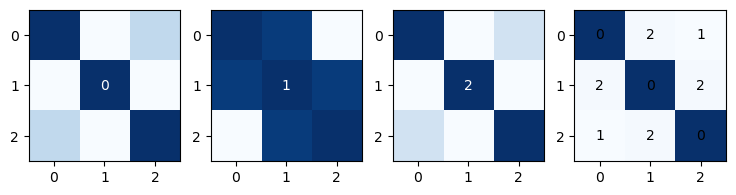

In [112]:
fig,axs = plt.subplots(1,4,figsize=(9,3))

for i in range(N):
    axs[i].imshow(np.log10(1-fidsarr[:,:,i]),cmap='Blues')
    axs[i].text(1,1,str(i),ha="center", va="center",color="w")

axs[3].imshow(np.log10(1-np.reshape(bests,(3,3))),cmap='Blues')
for i in range(N):
    for j in range(N):
        text = axs[3].text(j, i, np.reshape(bestModes,(3,3))[i, j],
                       ha="center", va="center", color="k")    
    
plt.show()

## 5 ion string

In [118]:
modetype='radial'
modextalk=True
K=1
N = 5

τ = 250*1e-6
#τ = τslow

trapspec = TrapSpec(νz, νr)
fidsarr = np.zeros((N,N,N))
devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, raman_freq, M)
for targets in itertools.combinations(range(N),2):
    for m in range(N):
        ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
        #Ωvals = Ω*ict.Ωvals_from_gaussian_crosstalk(N, targets, νz, M, bw)
        Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ,nneighΩ)
        mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
        simmodes = list(range(N)) if modextalk==True else [m]
        msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
        ρf, ionindices = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=simmodes,modetype=modetype, modetrunc=2)
        fidions = targets
        traceindices = [ionindices.index(i) for i in fidions]
        ρred = ρf.ptrace(traceindices)
        fid = (abs(ρred[0,0]) + abs(ρred[3,3]) + abs(2*ρred[3,0].imag))/2
        fidsarr[targets[0],targets[1],m] = fidsarr[targets[1],targets[0],m] = fid

In [119]:
bests = [np.max(fidsarr[i,j,:]) for i in range(N) for j in range(N)]
bestModes = [np.argmax(fidsarr[i,j,:]) for i in range(N) for j in range(N)]

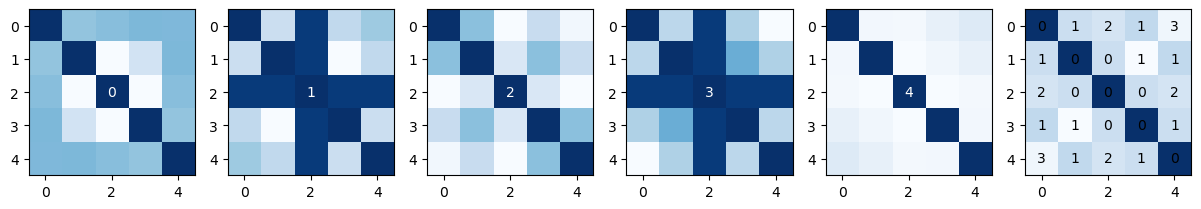

In [126]:
fig,axs = plt.subplots(1,N+1,figsize=(15,6))

for i in range(N):
    axs[i].imshow(np.log10(1-fidsarr[:,:,i]),cmap='Blues')
    axs[i].text(np.floor(N/2),np.floor(N/2),str(i),ha="center", va="center",color="w")

axs[N].imshow(np.log10(1-np.reshape(bests,(N,N))),cmap='Blues')
for i in range(N):
    for j in range(N):
        text = axs[N].text(j, i, np.reshape(bestModes,(N,N))[i, j],
                       ha="center", va="center", color="k")    
    
plt.show()